# Stacked Autoencoders

Inspired and modified from: https://github.com/ageron/handson-ml/blob/master/15_autoencoders.ipynb by Aurélien Géron

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import tensorflow as tf
import sys

from tensorflow.examples.tutorials.mnist import input_data

### To plot pretty figures inline in the notebook

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)
print(np.__version__)
print(matplotlib.__version__)

1.14.0
1.16.4
3.1.0


### Store the MNIST data in "mnist_data/" in the current working directory

In [4]:
mnist = input_data.read_data_sets("mnist_data/")

W0818 22:41:41.416762 140735651656576 deprecation.py:323] From <ipython-input-4-d20c61476fee>:1: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0818 22:41:41.418945 140735651656576 deprecation.py:323] From /Users/shusma/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0818 22:41:41.420751 140735651656576 deprecation.py:323] From /Users/shusma/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a f

Extracting mnist_data/train-images-idx3-ubyte.gz


W0818 22:41:41.665530 140735651656576 deprecation.py:323] From /Users/shusma/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0818 22:41:41.713168 140735651656576 deprecation.py:323] From /Users/shusma/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


### Result the default graph so you can have a fresh run

In [5]:
tf.reset_default_graph()

### Displays a digit inline on screen
* Takes in a 1-D array of 784 pixels representing an image

In [6]:
def display_digit(digit):
    plt.imshow(digit.reshape(28, 28), cmap="Greys", interpolation='nearest')

### Pass in 2 test images and see how they are reconstructed using the Autoencoder

* Reconstructs the session using the saved model
* Sets up the plot to display the original and reconstructed image side-by-side

In [7]:
def show_reconstructed_digits(X, outputs, model_path = None, num_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[5 : 5 + num_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * num_digits))
    for i in range(num_digits):
        plt.subplot(num_digits, 2, i * 2 + 1)
        display_digit(X_test[i])
        plt.subplot(num_digits, 2, i * 2 + 2)
        display_digit(outputs_val[i])

### Build a stacked autoencoder with 3 hidden layers
   * Number of inputs are 28 * 28 = 784, the number of pixels in any MNIST image
   * The hidden layers are symmetric and get progressively narrower
   * The narrowest layer is the codings
   * The number of inputs is equal to the number of outputs 

In [8]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

### Initialization and regularization

* The He initializer is used to initialize the weights of the neurons, this has proven to greatly **reduce the vanishing and exploding gradients** problem in neural networks
* The l2 regularizer is used to **prevent overfitting** of the neural network to the data

In [9]:
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(0.0001)

In [10]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [11]:
# dropout_rate = 0.3

# training = tf.placeholder_with_default(False, shape=(), name='training')
# X_drop = tf.layers.dropout(X, dropout_rate, training=training)

### Set up layers of the Autoencoder neural network

* We use a partial specification for tf.layers.dense to make it easier to read the code
* We use the ELU activation function which greatly reduces the problem of dying neurons
* The last layer does not have an activation function

In [12]:
from functools import partial

dense_layer = partial(tf.layers.dense,
                      activation=tf.nn.elu,
                      kernel_initializer=he_init,
                      kernel_regularizer=l2_regularizer)

hidden1 = dense_layer(X, n_hidden1)
hidden2 = dense_layer(hidden1, n_hidden2)
hidden3 = dense_layer(hidden2, n_hidden3)
outputs = dense_layer(hidden3, n_outputs, activation=None)

W0818 22:41:42.050546 140735651656576 deprecation.py:323] From <ipython-input-12-d2558c35dc4d>:8: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


### Set up the loss function and the optimizer

* Use the MSE to calculate reconstruction losses - compare outputs with the inputs and not labels (unsupervised!)
* The regularization losses from each layer are added to find the total loss

*TensorFlow automatically adds nodes to compute the regularization losses for each layer to a collection which can be accessed using the key tf.GraphKeys.REGULARIZATION_LOSSES*

In [13]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(0.01)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

#### The saver is used to save a model to directory, this model can be reloaded into the session when needed

In [14]:
saver = tf.train.Saver()

### Train the model using training data

* Note that we do not use the labels from each MNIST batch
* At the end of each epoch write the model out to a checkpoint

In [15]:
n_epochs = 6
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size

        for iteration in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})

        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   
        print("\r{}".format(epoch), "Train MSE:", loss_train)

        saver.save(sess, "./stacked_autoencoder.ckpt")

0 Train MSE: 0.023045748
1 Train MSE: 0.012954489
2 Train MSE: 0.0109163225
3 Train MSE: 0.010516152
4 Train MSE: 0.011075461
5 Train MSE: 0.0109407585


W0818 22:42:39.454577 140735651656576 deprecation.py:323] From /Users/shusma/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


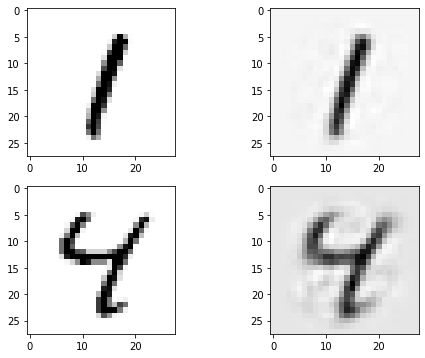

In [16]:
# With regularization
show_reconstructed_digits(X, outputs, "./stacked_autoencoder.ckpt")

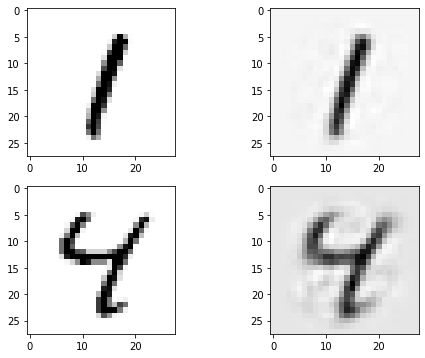

In [17]:
# Without regularization
show_reconstructed_digits(X, outputs, "./stacked_autoencoder.ckpt")